<a href="https://colab.research.google.com/github/Matteo-Candi/Fine-Tuning-with-LoRA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install datasets

In [3]:
from transformers import set_seed, BertTokenizer, TFBertModel, TFBertForSequenceClassification
from datasets import load_dataset, concatenate_datasets
import tensorflow as tf

from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

In [4]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

# Dataset

### Full Dataset 211k

In [ ]:
dataset = load_dataset("go_emotions", "raw").shuffle(seed=17)
dataset = dataset.remove_columns(['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear'])
dataset = dataset['train']

split_dataset = dataset.train_test_split(.1, seed=17)
df_train = split_dataset['train'].to_pandas()
df_test = split_dataset['test'].to_pandas()

count_train = df_train.eq(1).mean() * 100
count_test = df_test.eq(1).mean() * 100

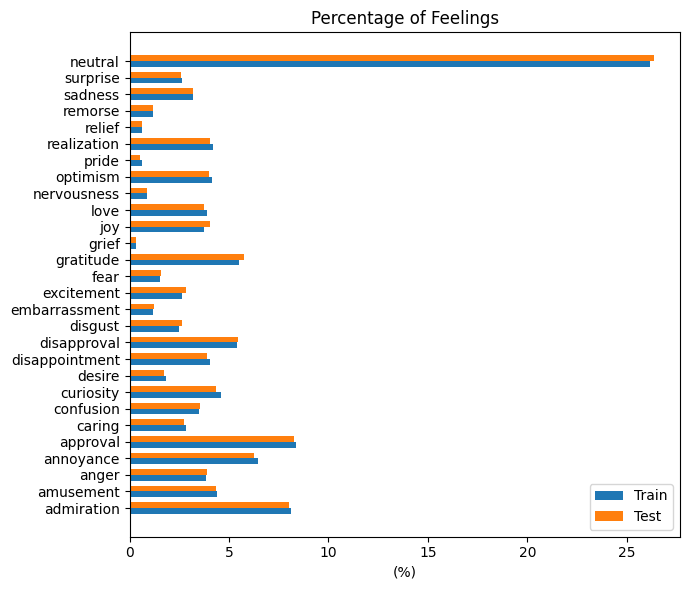

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
bar_width = 0.35
index = range(len(count_train.index[1:]))
bars_train = ax.barh(index, count_train.values[1:], bar_width, label='Train')
bars_test = ax.barh([i + bar_width for i in index], count_test.values[1:], bar_width, label='Test')
plt.yticks([i + bar_width/2 for i in index], count_train.index[1:])
plt.xlabel('(%)')
plt.title('Percentage of Feelings')
plt.legend()
plt.tight_layout()
plt.show()

### Small Dataset 54k

In [5]:
dataset_small = load_dataset("go_emotions", "simplified").shuffle(seed=17)
labels = dataset_small['train'].features['labels'].feature.names
dataset_small = dataset_small.remove_columns('id')

df_train_small = dataset_small['train'].to_pandas()
df_val_small = dataset_small['validation'].to_pandas()
df_test_small = dataset_small['test'].to_pandas()

model_name = "bert-base-cased"
num_labels = 28

tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
df_train_small

,text,labels
0,Here is their other hot wallet: the story behind,[27]
1,Look at the spine on that kid - he must get it...,"[26, 27]"
2,That can be true...,[27]
3,"Yeah, The Donald seems to spread its purging m...",[3]
4,you get an upvote for that username! I wish I ...,"[0, 20]"
...,...,...
43405,Yeah there's no reason to believe you staying ...,"[3, 10]"
43406,No lie his jumpshot is pretty If he can hit th...,[0]
43407,Redditors can really come together in a time o...,"[4, 20]"
43408,[NAME] was horribly inconsistent this year,[14]


In [7]:
def get_df_summary(df):
    label_column = df['labels'].to_list()
    flatten_col = list(itertools.chain(*label_column))
    freq_dict = dict(Counter(flatten_col))
    freq_list = list(dict(sorted(freq_dict.items())).values())
    rel_freq_list = [el / sum(freq_list) * 100 for el in freq_list]

    return rel_freq_list

In [8]:
# Get dataframes info.
train_freq = get_df_summary(df_train_small)
val_freq = get_df_summary(df_val_small)
test_freq = get_df_summary(df_test_small)

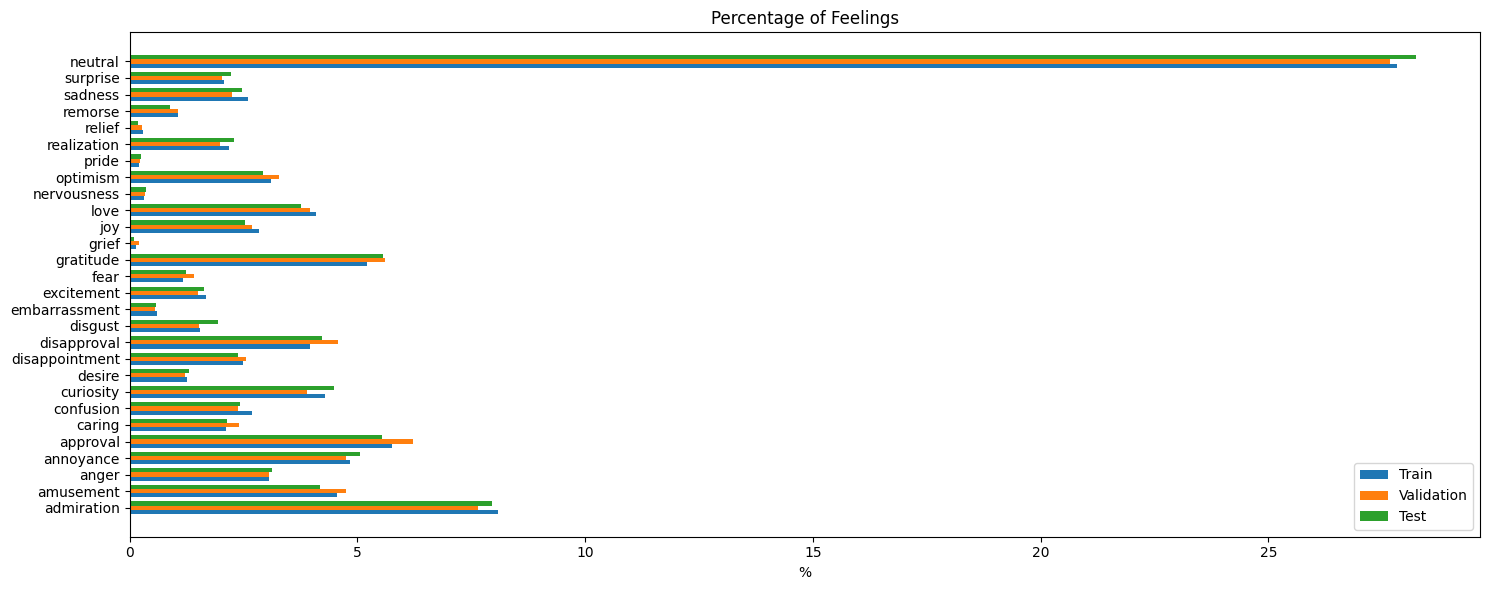

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
index = np.arange(len(train_freq))
bars_train = ax.barh(index, train_freq, bar_width, label='Train')
bars_val = ax.barh(index + bar_width, val_freq, bar_width, label='Validation')
bars_test = ax.barh(index + 2*bar_width, test_freq, bar_width, label='Test')
plt.xlabel('%')
plt.title('Percentage of Feelings')
plt.yticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
def tokenizer_func(text):
    '''
    Tokenizing the text using the BERT tokenizer.
    '''
    # Checking there is just one tokenization up to 316 and the second longest one is 120.
    # token_lengths = [sum(tokenized_train[i][0] != 0) for i in range(len(tokenized_train))]
    return tokenizer(text, padding = 'max_length', max_length = 120, return_tensors = "tf", truncation=True)

def one_hot_func(indices):
    '''
    Converting a value in one hot encode vector.
    '''
    one_hot_encoding = np.zeros(28, dtype=int)
    one_hot_encoding[indices] = 1
    return {'labels': one_hot_encoding}

def process_dataset_func(dataset):
    '''
    Processing the dataset to make it readable from the model.
    '''
    processed_dataset = dataset.map(lambda x: tokenizer_func(x['text']))
    processed_dataset = processed_dataset.map(lambda x: one_hot_func(x['labels']))
    processed_dataset = processed_dataset.remove_columns('text')
    return processed_dataset

In [11]:
dataset_small = process_dataset_func(dataset_small)

In [12]:
# tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset_small['train']['input_ids'], dataset_small['train']['labels']))
# tf_dataset_validation = tf.data.Dataset.from_tensor_slices((dataset_small['validation']['input_ids'], dataset_small['validation']['labels']))
# tf_dataset_test = tf.data.Dataset.from_tensor_slices((dataset_small['test']['input_ids'], dataset_small['test']['labels']))


batch_size = 32
tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset_small['train']['input_ids'], dataset_small['train']['labels'])).batch(batch_size)
tf_dataset_validation = tf.data.Dataset.from_tensor_slices((dataset_small['validation']['input_ids'], dataset_small['validation']['labels'])).batch(batch_size)
tf_dataset_test = tf.data.Dataset.from_tensor_slices((dataset_small['test']['input_ids'], dataset_small['test']['labels'])).batch(batch_size)


# Reshape labels to match the model output.
tf_dataset_train = tf_dataset_train.map(lambda input_ids, l: (tf.squeeze(input_ids, axis=1), tf.reshape(l, (1, -1))))
tf_dataset_validation = tf_dataset_validation.map(lambda input_ids, l: (tf.squeeze(input_ids, axis=1), tf.reshape(l, (1, -1))))
tf_dataset_test = tf_dataset_test.map(lambda input_ids, l: (tf.squeeze(input_ids, axis=1), tf.reshape(l, (1, -1))))

In [13]:
len(dataset_small['train']['labels'])

43410

# Model

In [21]:
pretrained_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
pretrained_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_113 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 108331804 (413.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, num_labels, threshold = .4):
        super(BaseModel, self).__init__()
        self.num_labels = num_labels
        self.threshold = threshold

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = self.num_labels)

        # # This is to freeze the weights of the pretrained model.
        # for _ , param in self.model.named_parameters():
        #     param.requires_grad=False

        self.softmax = tf.keras.layers.Softmax()

    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)
        model_output = self.softmax(logits[0])


        # [TODO] Is all this below needed?
        # # Define a threshold allowing the model to predict more than one class.
        # predictions = tf.where(model_output > self.threshold).numpy()

        # if len(predictions) > 1:
        #     tf.reshape(predictions, [-1])
        #     output = np.zeros_like(predictions[0], dtype=int)
        #     output[predictions] = 1

        # # return just the maximum when only one or none values exceed the threshold.
        # else:
        #     output = np.zeros_like(model_output[0], dtype=int)
        #     output[np.argmax(model_output)] = 1

        return model_output

In [23]:
base_model = BaseModel(model_name, num_labels, threshold = .3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

base_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

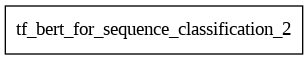

In [25]:
tf.keras.utils.plot_model(pretrained_model, show_shapes = True)

In [26]:
num_epochs = 1

# Train the model
base_model_history = base_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-26-6605ac685f53>", line 4, in <cell line: 4>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,28] labels_size=[1,896]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_227594]

In [ ]:
base_model_history

Sources:
- [Multi class with Bert](https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb)
- [Dataset Preprocessing](https://huggingface.co/docs/datasets/v1.12.1/use_dataset.html)

In [ ]:
# Create an iterator for the dataset
iterator = iter(tf_dataset_train)

# Iterate through the dataset using the iterator
while True:
    try:
        # Get the next batch of data
        input_ids, labels = next(iterator)

        # Access and process each batch of data
        print("Input IDs:", input_ids)
        print("Labels:", labels)
        break
    except StopIteration:
        # End of dataset
        break


Input IDs: tf.Tensor(
[[ 101 3446 1110 ...    0    0    0]
 [ 101 4785 1120 ...    0    0    0]
 [ 101 1337 1169 ...    0    0    0]
 ...
 [ 101  146  112 ...    0    0    0]
 [ 101 2066 1225 ...    0    0    0]
 [ 101 2814  117 ...    0    0    0]], shape=(32, 120), dtype=int32)
Labels: tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 